# Lab 5

Daniel Alfredo Rayo Roldan

Gerardo Gabriel Pineda Riveiro

https://github.com/DanielRasho/DS-lab6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import warnings
from textblob import TextBlob
import requests
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import xgboost as xgb
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

## Cargado de Datos

Para este reporte se trabajó con un junton de datos igual a , que consistian 7613 en mensajes que tenian representaban mensajes positivos o negativos, las frases estaban escritas de un modo que solo usando el contexto y con conocimiento de la semantíca se podía entender si una frase representaba una catastrofe real o solamente figurada.

In [2]:
df_train = pd.read_csv("./data/train.csv")

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(f"Número de filas: {df_train.shape[0]}")
print(f"Número de columnas: {df_train.shape[1]}")
print(f"\nColumnas: {list(df_train.columns)}")
print(f"\nTipos de datos:")
df_train.dtypes

Número de filas: 7613
Número de columnas: 5

Columnas: ['id', 'keyword', 'location', 'text', 'target']

Tipos de datos:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Análisis Exploratorio

### Valores faltantes

Del dataset se puede observar que hay una cantidad considerable de datos nulos en la variable de localización, pero es esperable considerando que los datos fueron extraidos de las redes sociales. Se usaran `text` y `target` no presentan datos nulos, así que no se realizara ningún preprocesamiento para datos nulos.

In [4]:
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores Faltantes': missing_values.values,
    'Porcentaje': missing_percent.values
})
missing_df

,Columna,Valores Faltantes,Porcentaje
0,id,0,0.000000
1,keyword,61,0.801261
2,location,2533,33.272035
3,text,0,0.000000
4,target,0,0.000000


### Distribución de variable objetivo
Los datos no se encuentran del todo balanceados, se cuentan aproximadamente con 4000 mensajes positivos y 3000 negativos, es decir  una diferencia de 1000 datos, por lo que es probable que los modelos entrenados en siguientes secciones tengan problemas para identificar mensajes negativos.

Tweets NO desastre (0): 4342 (57.0%)
Tweets de desastre (1): 3271 (43.0%)


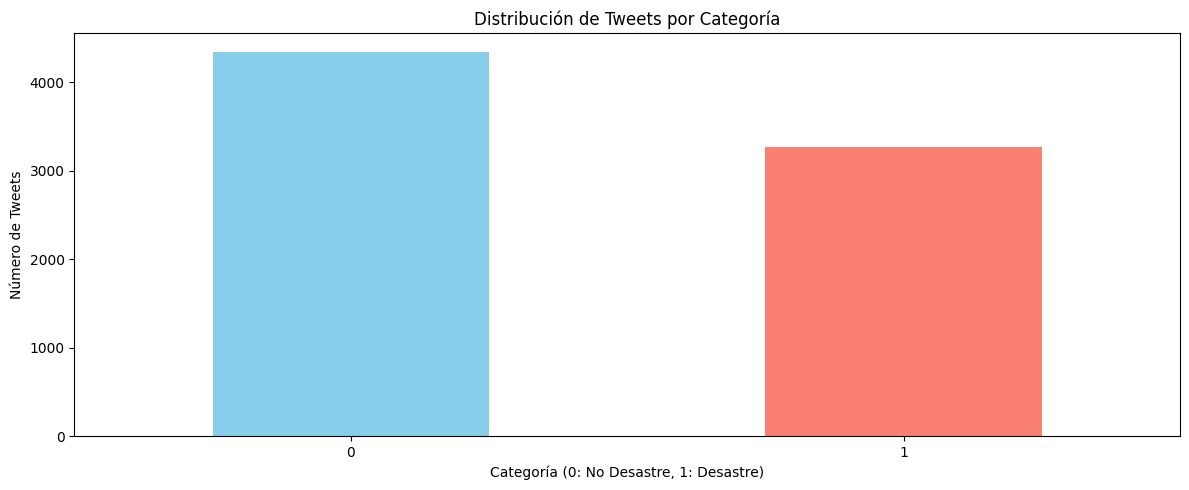

In [5]:
target_counts = df_train['target'].value_counts()
print(f"Tweets NO desastre (0): {target_counts[0]} ({target_counts[0]/len(df_train)*100:.1f}%)")
print(f"Tweets de desastre (1): {target_counts[1]} ({target_counts[1]/len(df_train)*100:.1f}%)")

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

target_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Tweets por Categoría')
ax1.set_xlabel('Categoría (0: No Desastre, 1: Desastre)')
ax1.set_ylabel('Número de Tweets')
ax1.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [6]:
print("\n=== EJEMPLOS DE TWEETS ===")
print("Tweets de DESASTRE:")
for i, tweet in enumerate(df_train[df_train['target']==1]['text'].head(3)):
    print(f"{i+1}. {tweet}")

print("\nTweets NO de desastre:")
for i, tweet in enumerate(df_train[df_train['target']==0]['text'].head(3)):
    print(f"{i+1}. {tweet}")


=== EJEMPLOS DE TWEETS ===
Tweets de DESASTRE:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2. Forest fire near La Ronge Sask. Canada
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

Tweets NO de desastre:
1. What's up man?
2. I love fruits
3. Summer is lovely


# Preprocesamiento

Se descargan las stopword del paquete de nltk y se crea el tokenizador de tweets de la libreria nltk.

In [7]:
nltk.download("stopwords"); nltk.download("wordnet"); nltk.download("omw-1.4")
tt = TweetTokenizer(preserve_case=not True, reduce_len=True, strip_handles=False)
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/smaug/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/smaug/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/smaug/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Como el idioma del set es ingles se obtienen los stopwords en este idio y nos aseguramos que las palabras negativas que se queden porque estas son valiosas para el analiss

In [8]:
stopwords = set(nltk_stop.words("english"))
negs = {"no","not","n't"}
stopwords = {w for w in stopwords if w.lower() not in negs}

Se crean expresiones regualres especificas para cada parte de la limpieza que se quiere quitar.

In [9]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
APOSTROPHES_RE = re.compile(r"[’`´]")
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)
NUMBER_RE = re.compile(r"\b\d+(?:[.,]\d+)*\b")

PUNCT_TABLE = str.maketrans("", "", string.punctuation)

Se crea una funcion donde se mapean todas las palabras y se quita lo siguiente:
- Se convirtio todo a minusculas.
- Se quitar los caracteres especiales que aparecen como *#*, *@* o los *apostrofes*
- Se quitar las url
- Se decidio quitar los emojis pero se quedo con una flag por si se quieren dejar.
- Se quitaron los signos de puntuación.
- Se quitaron las stopwords
- Se quitaron los numeros menos el 911

In [10]:
def remove_non_ascii(text: str) -> str:
    return re.sub(r"[^\x00-\x7F]+", " ", text)

def count_pattern(pat, text):
    return len(pat.findall(text))

def clean_raw(text: str) -> dict:
    original = text

    
    text = text.lower()

    urls = mentions = emojis = hashtags = numbers = 0

    urls = count_pattern(URL_RE, text)
    text = URL_RE.sub(" ", text)

    mentions = count_pattern(MENTION_RE, text)
    text = MENTION_RE.sub(" ", text)

    hashtags = count_pattern(HASHTAG_RE, text)
    text = HASHTAG_RE.sub(lambda m: m.group(1), text)

    text = APOSTROPHES_RE.sub("'", text)

    if True: # Cambiar esto para cambiarlos emojis (si queres rayo)
        emojis = len(EMOJI_RE.findall(text))
        text = EMOJI_RE.sub(" ", text)

    # Aqui estan los numeros solo vamos a dejar el 911
    def num_filter(m):
        tok = m.group(0)
        return tok if tok in {"911"} else " "
    numbers = len(NUMBER_RE.findall(text))
    text = NUMBER_RE.sub(num_filter, text)

    text = text.translate(PUNCT_TABLE)

    text = remove_non_ascii(text)

    text = re.sub(r"\s+", " ", text).strip()

    return {
        "text_raw": original,
        "text_clean_raw": text,
        "urls_removed": urls,
        "mentions_removed": mentions,
        "emojis_removed": emojis,
        "hashtags_unhashed": hashtags,
        "numbers_affected": numbers
    }

clean_rows = df_train["text"].map(clean_raw)
clean_df = pd.DataFrame(list(clean_rows))
df_train = pd.concat([df_train, clean_df], axis=1)

In [11]:
def tokenize_and_normalize(text: str):
    tokens = []
    toks = tt.tokenize(text)
    toks = [t for t in toks if all(ch not in string.punctuation for ch in t)]
    toks = [wnl.lemmatize(t) for t in toks]

    toks = [t for t in toks if t.lower() not in stopwords]
    tokens = toks

    tokens = [t.strip() for t in tokens if t.strip() != ""]
    return tokens

df_train["tokens"] = df_train["text_clean_raw"].map(tokenize_and_normalize)
df_train["text_clean"] = df_train["tokens"].map(lambda ts: " ".join(ts))

In [12]:
df_train["len_raw"] = df_train["text"].str.split().map(len)
df_train["len_clean"] = df_train["tokens"].map(len)

In [13]:
print(df_train[["text_clean_raw","tokens","text_clean"]].head(1))

                                      text_clean_raw  \
0  our deeds are the reason of this earthquake ma...   

                                              tokens  \
0  [deed, reason, earthquake, may, allah, forgive...   

                                   text_clean  
0  deed reason earthquake may allah forgive u  


### Frecuencia de palabras por categoría
Tras el preprocesamiento se contó las palabras más frecuentes en ambas categorías de tweets.

In [14]:
disaster_tweets = df_train[df_train['target'] == 1]['text_clean']
non_disaster_tweets = df_train[df_train['target'] == 0]['text_clean']

def get_word_frequencies(texts, top_n=20):
    """
    Obtiene las palabras más frecuentes de una lista de textos
    """
    all_words = []
    for text in texts:
        words = text.split()
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Obtener palabras más frecuentes para cada categoría
disaster_freq = get_word_frequencies(disaster_tweets)
non_disaster_freq = get_word_frequencies(non_disaster_tweets)

print("TOP 20 PALABRAS MÁS FRECUENTES - TWEETS DE DESASTRE:")
for word, freq in disaster_freq:
    print(f"{word}: {freq}")

print("\nTOP 20 PALABRAS MÁS FRECUENTES - TWEETS NO DE DESASTRE:")
for word, freq in non_disaster_freq:
    print(f"{word}: {freq}")

TOP 20 PALABRAS MÁS FRECUENTES - TWEETS DE DESASTRE:
fire: 265
wa: 174
news: 136
via: 121
disaster: 117
california: 115
suicide: 110
amp: 109
no: 108
police: 107
people: 106
u: 105
family: 105
ha: 105
home: 101
train: 100
building: 95
not: 93
killed: 93
like: 92

TOP 20 PALABRAS MÁS FRECUENTES - TWEETS NO DE DESASTRE:
like: 255
im: 244
wa: 219
not: 204
amp: 193
get: 185
new: 171
ha: 152
no: 146
u: 146
dont: 141
one: 137
body: 117
time: 104
video: 102
via: 99
would: 97
day: 96
love: 95
people: 92


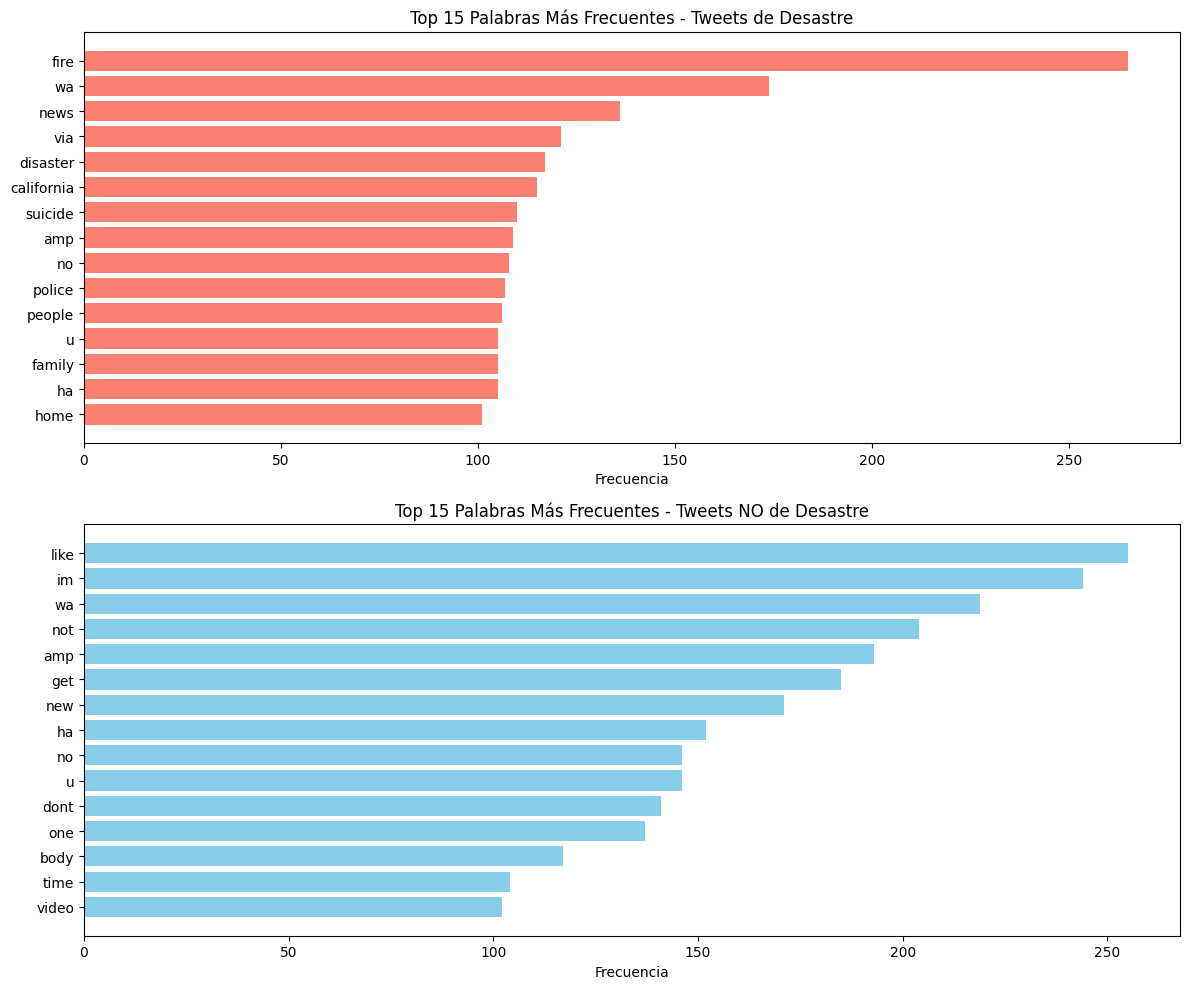

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Palabras más frecuentes en tweets de desastre
disaster_words = [word for word, freq in disaster_freq]
disaster_counts = [freq for word, freq in disaster_freq]

ax1.barh(disaster_words[:15][::-1], disaster_counts[:15][::-1], color='salmon')
ax1.set_title('Top 15 Palabras Más Frecuentes - Tweets de Desastre')
ax1.set_xlabel('Frecuencia')

# Palabras más frecuentes en tweets NO de desastre
non_disaster_words = [word for word, freq in non_disaster_freq]
non_disaster_counts = [freq for word, freq in non_disaster_freq]

ax2.barh(non_disaster_words[:15][::-1], non_disaster_counts[:15][::-1], color='skyblue')
ax2.set_title('Top 15 Palabras Más Frecuentes - Tweets NO de Desastre')
ax2.set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

Se puede observar como en las palabras más frecuentes en tweets trágicos hacen referencia cuantan con algunos términos que cuentan con pocos terminos figurados, en caso tenerlos siguen teniendo significados negativos. Por el contrario las palabras de tweets inofensivos, no presentan ninguna de estas palabras, de hecho una de las palabras más frecuente es 'ha' la onomatopeya de reirse : 'ha ha ha'.

### Analísis de Bigramas y Trigramas

#### Bigramas
Si juntamos las palabras de pares para hacer bigramas y las asociamos con el sentimiento de la oración a la que pertenecen la diferencia de gravedad aumenta, al contar con 2 palabras se cuenta con mayor contexto, y es mucho más sencillo saber si las frases son catastróficas o no.

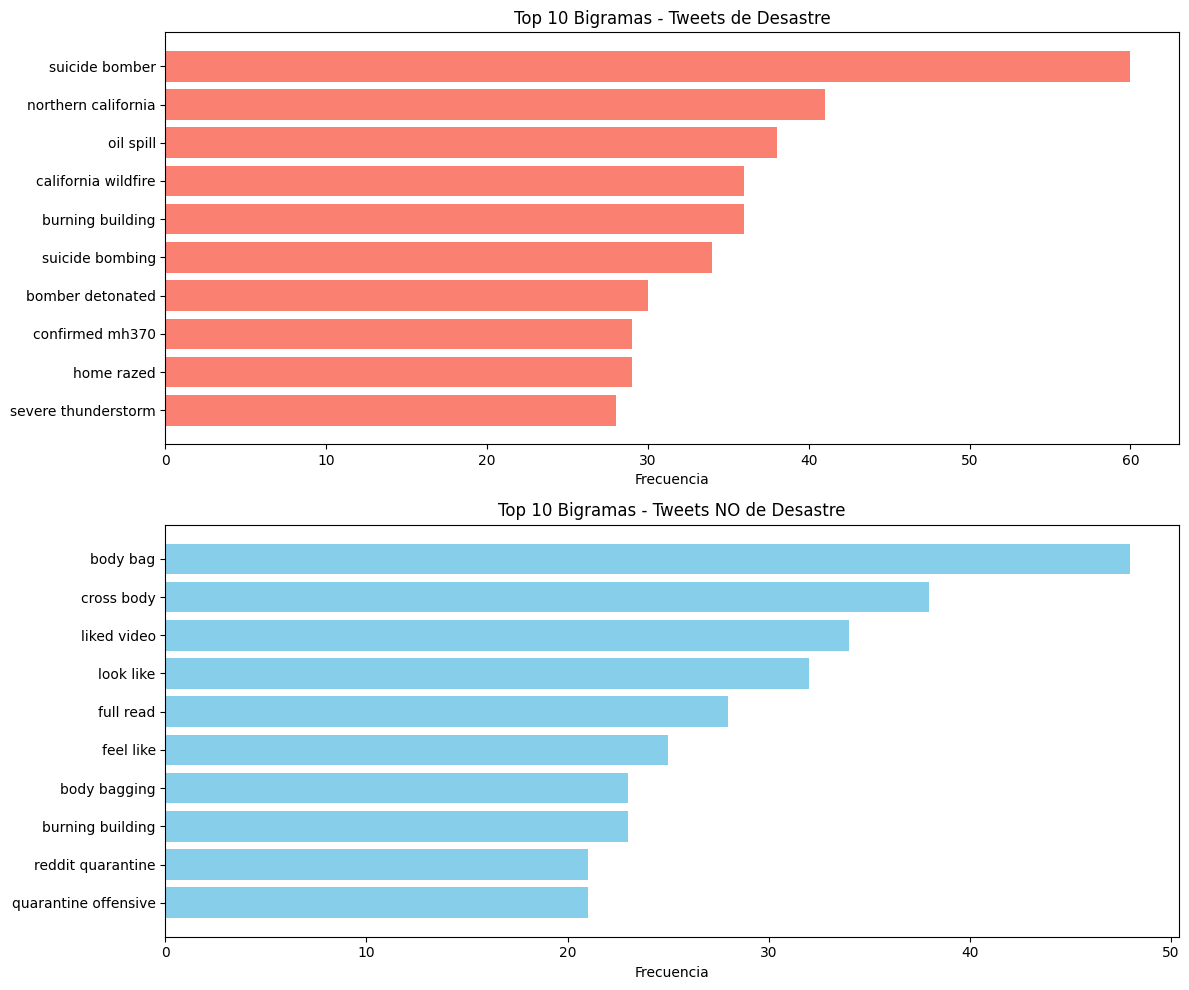

In [16]:
def get_ngrams(texts, n=2, top_n=15):
    all_ngrams = []
    for text in texts:
        words = text.split()
        if len(words) >= n:
            text_ngrams = list(ngrams(words, n))
            all_ngrams.extend(text_ngrams)
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_n)

# Obtener bigramas más frecuentes
disaster_bigrams = get_ngrams(disaster_tweets, n=2, top_n=15)
non_disaster_bigrams = get_ngrams(non_disaster_tweets, n=2, top_n=15)

# Visualización de bigramas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Bigramas de tweets de desastre
disaster_bigram_labels = [' '.join(bigram) for bigram, freq in disaster_bigrams]
disaster_bigram_counts = [freq for bigram, freq in disaster_bigrams]

ax1.barh(disaster_bigram_labels[:10][::-1], disaster_bigram_counts[:10][::-1], color='salmon')
ax1.set_title('Top 10 Bigramas - Tweets de Desastre')
ax1.set_xlabel('Frecuencia')

# Bigramas de tweets NO de desastre
non_disaster_bigram_labels = [' '.join(bigram) for bigram, freq in non_disaster_bigrams]
non_disaster_bigram_counts = [freq for bigram, freq in non_disaster_bigrams]

ax2.barh(non_disaster_bigram_labels[:10][::-1], non_disaster_bigram_counts[:10][::-1], color='skyblue')
ax2.set_title('Top 10 Bigramas - Tweets NO de Desastre')
ax2.set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()


Efectivamente los bigramas de tweets inofensivos, en el peor de los casos pueden tener una cognotación de queja o descaró, pero sin llegar a significar muerte o enfermedad.

#### Trigramas

Por último para el análisis de trigramas se puede descubrir un patrón común en los tweets catastróficos y es que hablan de razas, armas u muerte. Cosa que en los tweets que se consideran como positivos no pasa, en esta categoría predominan más los trigramas relacionados a problemas económicos o de contenido ofensivo, pero no catastrófico.

In [17]:
disaster_trigrams = get_ngrams(disaster_tweets, n=3, top_n=10)
non_disaster_trigrams = get_ngrams(non_disaster_tweets, n=3, top_n=10)

print("\nTOP 10 TRIGRAMAS - TWEETS DE DESASTRE:")
for trigram, freq in disaster_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

print("\nTOP 10 TRIGRAMAS - TWEETS NO DE DESASTRE:")
for trigram, freq in non_disaster_trigrams:
    print(f"{' '.join(trigram)}: {freq}")


TOP 10 TRIGRAMAS - TWEETS DE DESASTRE:
suicide bomber detonated: 30
northern california wildfire: 29
latest home razed: 28
home razed northern: 28
pkk suicide bomber: 28
bomber detonated bomb: 28
razed northern california: 27
16yr old pkk: 27
old pkk suicide: 27
family sue legionnaire: 26

TOP 10 TRIGRAMAS - TWEETS NO DE DESASTRE:
cross body bag: 23
reddit quarantine offensive: 21
quarantine offensive content: 20
pick fan army: 17
reddits new content: 16
new content policy: 16
china stock market: 16
stock market crash: 16
full read ebay: 15
ignition knock detonation: 15


## Modelos de Clasificación de sentimientos

Terminado el análisis exploratorio, en esta sección se utilizarán los textos limpios para entrenar modelos que clasifiquen si un tweet es catastrófico o inofensivo. Se empleara esta división de datos: 

- **Entrenamiento** - 75%
- **Test** - 25%

Se utilizara **GridSearch** para descubrimiento de parámetros óptimos, y se trabajara con 3 diferentes algoritmos para descubrir el que tiene mejor rendimiento.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train["text_clean"], df_train["target"], 
    test_size=0.25, 
    random_state=42,
    stratify=df_train["target"]
)

In [19]:
def train_and_optimize_model(pipeline, param_grid, X_train, y_train, model_name):
    print(f"\n=== ENTRENANDO {model_name.upper()} ===")
    print("Ejecutando Grid Search para encontrar mejores hiperparámetros...")
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"✓ {model_name} entrenado")
    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n=== EVALUACIÓN {model_name.upper()} ===")
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    print(f"\nReporte de clasificación detallado:")
    target_names = ['Positivo (0)', 'Negativo (1)']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    return {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc
        }
    }
    
def plot_confusion_matrices(model_result, y_test, model_name):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    cm = confusion_matrix(y_test, model_result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['Positivo (0)', 'Negativo (1)'],
               yticklabels=['Positivo (0)', 'Negativo (1)'])
    
    f1 = model_result['metrics']['f1_score']
    accuracy = model_result['metrics']['accuracy']
    ax.set_title(f'Matriz de Confusión - {model_name}\nF1-Score: {f1:.3f} | Accuracy: {accuracy:.3f}')
    ax.set_ylabel('Valor Real')
    ax.set_xlabel('Predicción')
    
    plt.tight_layout()
    plt.show()

### Regresión Logística

In [20]:
def create_logistic_regression_model():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            lowercase=True,
            stop_words='english'
        )),
        ('classifier', LogisticRegression(
            random_state=42,
            max_iter=1000,
            solver='liblinear'
        ))
    ])
    
    # Grid de hiperparámetros para optimización
    param_grid = {
        'tfidf__max_features': [8000, 10000, 12000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.1, 1.0, 10.0]
    }
    
    return pipeline, param_grid

In [21]:
lr_pipeline, lr_param_grid = create_logistic_regression_model()
lr_model = train_and_optimize_model(lr_pipeline, lr_param_grid, 
                                   X_train, y_train, "Regresión Logística")
lr_results = evaluate_model(lr_model, X_test, y_test, "Regresión Logística")


=== ENTRENANDO REGRESIÓN LOGÍSTICA ===
Ejecutando Grid Search para encontrar mejores hiperparámetros...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✓ Regresión Logística entrenado
Mejores parámetros: {'classifier__C': 1.0, 'tfidf__max_features': 8000, 'tfidf__ngram_range': (1, 1)}
Mejor F1-Score (CV): 0.7302

=== EVALUACIÓN REGRESIÓN LOGÍSTICA ===
Accuracy: 0.8162
Precision: 0.8431
Recall: 0.7029
F1-Score: 0.7667
ROC-AUC: 0.8675

Reporte de clasificación detallado:
              precision    recall  f1-score   support

Positivo (0)       0.80      0.90      0.85      1086
Negativo (1)       0.84      0.70      0.77       818

    accuracy                           0.82      1904
   macro avg       0.82      0.80      0.81      1904
weighted avg       0.82      0.82      0.81      1904



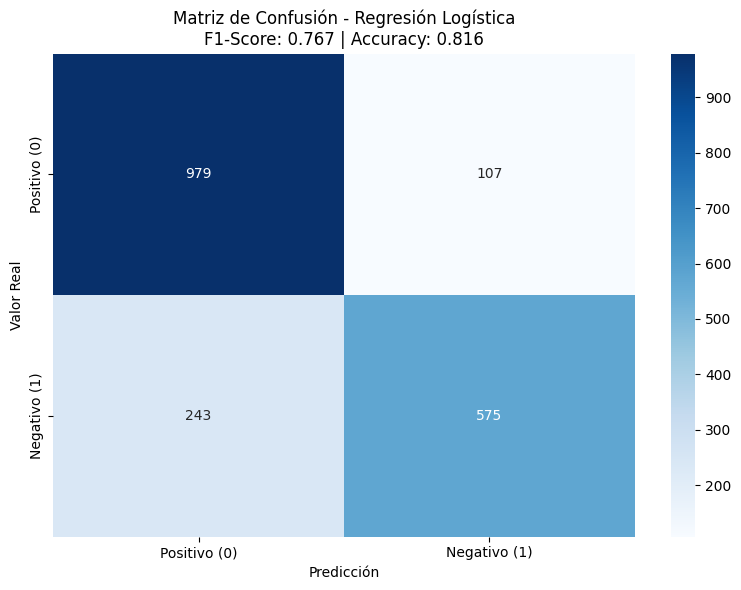

In [22]:
plot_confusion_matrices(lr_results, y_test, "Regresión Logística")

Como se esperaba por el desbalance de datos el modelo es mejor clasificando tweets positivos que negativos, principalmente confundiendo los positivos negativos por positivos. Sin embargo, los estadísticas son favorables pudiendod clasificar poco más del 80% de los datos analizados.

### Support Vector Machines

In [23]:
def create_svm_model():
    """
    Crea pipeline de SVM con TF-IDF
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            lowercase=True,
            stop_words='english'
        )),
        ('classifier', SVC(
            kernel='linear',
            random_state=42,
            probability=True  # Para calcular ROC-AUC
        ))
    ])
    
    # Grid de hiperparámetros para optimización
    param_grid = {
        'tfidf__max_features': [8000, 10000, 12000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.1, 1.0, 10.0]
    }
    
    return pipeline, param_grid

In [24]:
svm_pipeline, svm_param_grid = create_svm_model()
svm_model = train_and_optimize_model(svm_pipeline, svm_param_grid, 
                                   X_train, y_train, "SVM")
svm_results = evaluate_model(svm_model, X_test, y_test, "SVM")


=== ENTRENANDO SVM ===
Ejecutando Grid Search para encontrar mejores hiperparámetros...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✓ SVM entrenado
Mejores parámetros: {'classifier__C': 1.0, 'tfidf__max_features': 8000, 'tfidf__ngram_range': (1, 2)}
Mejor F1-Score (CV): 0.7296

=== EVALUACIÓN SVM ===
Accuracy: 0.8083
Precision: 0.8159
Recall: 0.7152
F1-Score: 0.7622
ROC-AUC: 0.8611

Reporte de clasificación detallado:
              precision    recall  f1-score   support

Positivo (0)       0.80      0.88      0.84      1086
Negativo (1)       0.82      0.72      0.76       818

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



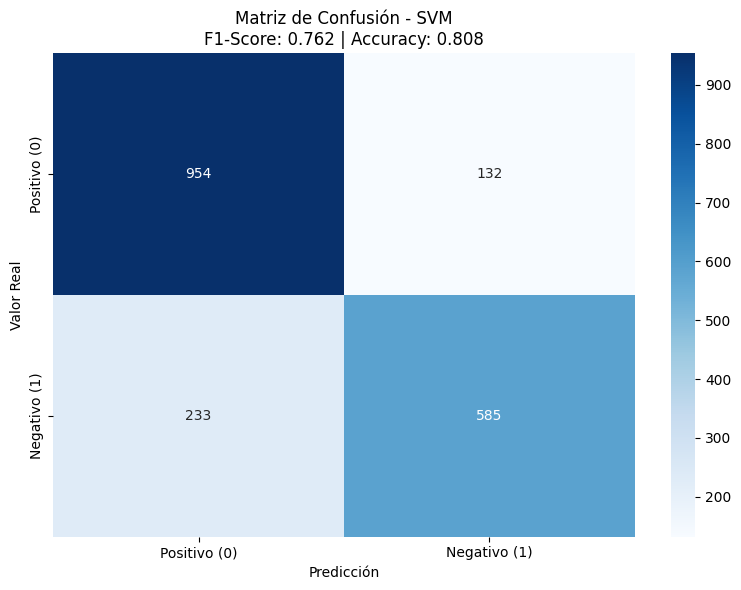

In [25]:
plot_confusion_matrices(svm_results, y_test, "SVM")

El modelo hecho con SVM tuvo un rendimiento sumament similar al realizado con regresión logística. Sin embargo, se tomó mucho más tiempo en entrenar, al rededor de 20 veces más (2 min aproximadamente), y a pesar de hecho tuvo un accuracy de 81%, 1% menor que con regresión logística.

### XGBoost

In [26]:
def create_xgboost_model():
    """
    Crea pipeline de XGBoost con TF-IDF optimizado para sentimiento
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=15000,        # Más features para XGBoost
            ngram_range=(1, 3),        # Incluir trigramas para mejor contexto
            min_df=2,                  # Palabra debe aparecer al menos 2 veces
            max_df=0.95,               # Ignorar palabras muy frecuentes
            lowercase=True,
            stop_words='english',
            sublinear_tf=True,         # Escala logarítmica para TF
            use_idf=True,
            smooth_idf=True
        )),
        ('classifier', XGBClassifier(
            random_state=42,
            eval_metric='logloss',     # Para clasificación binaria
            use_label_encoder=False,   # Evitar warnings
            n_jobs=-1                  # Usar todos los cores
        ))
    ])
    
    param_grid = {
        # Parámetros TF-IDF
        'tfidf__max_features': [10000, 13000],    # 3 valores
        'tfidf__ngram_range': [(1, 2), (1, 3)],         # Incluir trigramas de nuevo
        'tfidf__min_df': [2],                        # Frecuencia mínima
    
        # Parámetros XGBoost principales
        'classifier__n_estimators': [150, 200, 250],    # 3 valores
        'classifier__max_depth': [3, 4, 5],             # Profundidad del árbol
        'classifier__learning_rate': [0.1, 0.15, 0.2], # Tasa de aprendizaje
        
        # Parámetros de regularización (importantes para texto)
        # 'classifier__subsample': [0.8, 0.9],           # Muestreo de filas
        'classifier__colsample_bytree': [0.8, 0.9],    # Muestreo de features
    }
    
    
    return pipeline, param_grid

In [27]:
xgboost_pipeline, xgboost_param_grid = create_xgboost_model()
xgboost_model = train_and_optimize_model(xgboost_pipeline, xgboost_param_grid, 
                                   X_train, y_train, "XGBoost")
xgboost = evaluate_model(xgboost_model, X_test, y_test, "XGBoost")


=== ENTRENANDO XGBOOST ===
Ejecutando Grid Search para encontrar mejores hiperparámetros...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✓ XGBoost entrenado
Mejores parámetros: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 250, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Mejor F1-Score (CV): 0.6967

=== EVALUACIÓN XGBOOST ===
Accuracy: 0.7831
Precision: 0.8179
Recall: 0.6369
F1-Score: 0.7162
ROC-AUC: 0.8451

Reporte de clasificación detallado:
              precision    recall  f1-score   support

Positivo (0)       0.77      0.89      0.82      1086
Negativo (1)       0.82      0.64      0.72       818

    accuracy                           0.78      1904
   macro avg       0.79      0.77      0.77      1904
weighted avg       0.79      0.78      0.78      1904



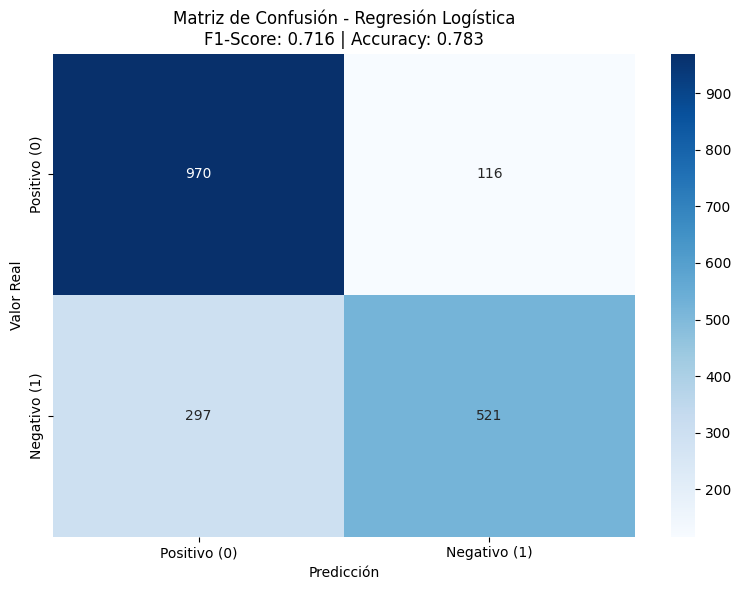

In [28]:
plot_confusion_matrices(xgboost, y_test, "Regresión Logística")

Por último se creo un modelo con XGBoost, el cúal tuvo el mayor tiempo de entrenamiento 3.5 minutos, sin embargo tuvo el peor rendimiento con un accuracy de 78%. Probablemente modelos de aprendizaje profundo podrían tener mejores predicciones pero también es cierto que requieren de más tiempo de aprendizaje y gran cantidad de datos, razón por la cuál no se escogieron para este estudio.

## Clasificación de tweets usando léxicos

Para la clasificación de palabras se utilizó el lexico creado por el usuario fnielsen y públicado en github, conteniendo 2477 en conjunto con un pontaje de que tan positivas o negativas son. 

In [33]:
def download_afinn_lexicon():
    url = "https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-111.txt"
    try:
        response = requests.get(url)
        afinn_dict = {}
        
        for line in response.text.strip().split('\n'):
            word, score = line.split('\t')
            afinn_dict[word] = int(score)
        
        print(f"✓ AFINN léxico cargado: {len(afinn_dict)} palabras")
        return afinn_dict
    except Exception as e:
        print(f"Error descargando AFINN: {e}")
        return {}

afinn_lexicon = download_afinn_lexicon()

✓ AFINN léxico cargado: 2477 palabras


In [34]:
def classify_word_sentiment(word):
    word_lower = word.lower().strip()
    
    if word_lower in afinn_lexicon:
        score = afinn_lexicon[word_lower]
        if score > 0:
            return 'positive', score, 'afinn'
        elif score < 0:
            return 'negative', abs(score), 'afinn'
    
    return 'neutral', 0, 'none'

In [35]:
def analyze_tweet_words(word_list):
    if not isinstance(word_list, list):
        return None
    
    word_analysis = []
    positive_words = []
    negative_words = []
    neutral_words = []
    
    total_positive_score = 0
    total_negative_score = 0
    
    for word in word_list:
        sentiment, score, source = classify_word_sentiment(word)
        
        word_info = {
            'word': word,
            'sentiment': sentiment,
            'score': score,
            'source': source
        }
        word_analysis.append(word_info)
        
        if sentiment == 'positive':
            positive_words.append(word)
            total_positive_score += score
        elif sentiment == 'negative':
            negative_words.append(word)
            total_negative_score += score
        else:
            neutral_words.append(word)
    
    positive_count = len(positive_words)
    negative_count = len(negative_words)
    
    net_score = total_positive_score - total_negative_score
    
    if positive_count > negative_count and positive_count > 0:
        tweet_sentiment = 'positive'
    elif negative_count > positive_count and negative_count > 0:
        tweet_sentiment = 'negative'
    elif net_score > 1:
        tweet_sentiment = 'positive'
    elif net_score < -1:
        tweet_sentiment = 'negative'
    else:
        tweet_sentiment = 'neutral'
    
    return {
        'word_analysis': word_analysis,
        'summary': {
            'tweet_sentiment': tweet_sentiment,
            'net_score': net_score,
            'negative_count': negative_count,
        }
    }

In [36]:
def analyze_dataframe_sentiment(df, words_column='words'):
    print(f"Analizando sentimiento de {len(df)} tweets...")
    
    results = []
    for i, word_list in enumerate(df[words_column]):
        if i % 1000 == 0:
            print(f"Procesando tweet {i}...")
        
        analysis = analyze_tweet_words(word_list)
        results.append(analysis)
    
    df = df.copy()
    
    df['net score'] = [r['summary']['net_score'] if r else 0 for r in results]
    df['overall sentiment'] = [r['summary']['tweet_sentiment'] if r else 0 for r in results]
    df['negative_count'] = [r['summary']['negative_count'] if r else 0 for r in results]
    return df

df_analyzed = analyze_dataframe_sentiment(df_train, "tokens")

Analizando sentimiento de 7613 tweets...
Procesando tweet 0...
Procesando tweet 1000...
Procesando tweet 2000...
Procesando tweet 3000...
Procesando tweet 4000...
Procesando tweet 5000...
Procesando tweet 6000...
Procesando tweet 7000...


Utilizando el lexicon se le dio puntaje a los tweets basados en la suma neta de palabras consideradas positivas menos la palabras negativas.

In [45]:
final = df_analyzed[['id', 'text_clean' , 'target' ,'net score', 'overall sentiment', 'negative_count']]

**Top 10 Tweets más negativos**

En general el 60% de los tweets más negativos corresponden con tweets que realmente estan categorizados como catastróficos, mostrando una correlación buena pero no prominente.

In [46]:
final.sort_values(by="net score", ascending=True).head(10)

,id,text_clean,target,net score,overall sentiment,negative_count
7472,10689,wreck wreck wreck wreck wreck wreck wreck wrec...,0,-26,negative,13
6980,10011,stop fucking saying whole nother sound fucking...,0,-19,negative,6
6814,9761,im trapped damn gas pump two suv either side f...,0,-14,negative,4
6414,9172,suicide bomber target saudi mosque least dead ...,1,-13,negative,5
160,231,horrible accident man died wing airplane wtf b...,1,-12,negative,4
2154,3091,died horrible death trapped ship knew wa risk,1,-12,negative,5
2019,2898,real shit damage bitch,0,-12,negative,3
2410,3469,update nopassenger metro train derails causing...,1,-12,negative,5
2844,4089,crime killeddisplaced million systematic tortu...,1,-12,negative,5
472,682,illegal alien released obamadhs time charged r...,1,-12,negative,4


**Top 10 Tweets más positivos**

Por el contrario, el puntaje de negatividad es mucho más exacto para frases positivas, el 90% de los tweets positivos son realmente categorizados como positivos.

In [47]:
final.sort_values(by="net score", ascending=False).head(10)

,id,text_clean,target,net score,overall sentiment,negative_count
6992,10028,check want twister ticket vip experience see s...,0,14,positive,0
5033,7176,first impression glad hat man leaving lieu int...,0,11,positive,0
1001,1453,im not drake fan enjoy seeing bodybagging peop...,0,11,positive,0
6292,8989,today storm pas let tomorrow light greet kiss ...,1,10,positive,0
3382,4844,enjoyed show today great fun emergency non eva...,0,10,positive,1
3163,4541,enjoyed show today great fun emergency non eva...,0,10,positive,1
1909,2744,disillusioned lead character check happy go lu...,0,10,positive,2
6560,9386,yeah survived season movie let hope good hope,0,10,positive,0
132,191,aftershock back school kick wa great want than...,0,9,positive,0
5656,8068,coastal german shepherd rescue oc shared link ...,0,9,positive,0


# Conclusiones